In [2]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)



# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [3]:
!ls ../vars_refresh_oct2020/

CSV_nocorn_grid_0_25_degree_vars
CSV_nocorn_grid_1_0_degree_vars
CSV_nocorn_grid_2_5_degree_vars


In [4]:
raster_folder = r"../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/" # data refresh! nov 2020
# raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
# raster_folder = r"../vars/grid_2_5_degree_vars/" # data refresh!
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [5]:
# verify
for fi in day_files:
    print(fi)
    
print()

# verify
for fi in night_files:
    print(fi)

../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_March_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_April_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_May_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_June_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_July_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_August_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_September_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_October_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_November_2012.tif
../vars_refresh_oct2020/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_December_2012.tif
../vars_refresh_oct2020/CSV_noc

In [8]:
day_argmax = nanargmax(day_files)
night_argmax = nanargmax(night_files)
day_argmax

6

In [7]:
day_title = 'FY-{} Month of Maximum MODIS AFC - Daytime'.format(year)
plot_max_month(day_argmax, raster_folder, day_title)
night_title = 'FY-{} Month of Maximum MODIS AFC - Nighttime'.format(year)
plot_max_month(night_argmax, raster_folder, night_title)

IndexError: tuple index out of range

# iterate over some years

In [9]:
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]

days, nights=[],[]
day_an, night_an = [],[]
# for year in range(2003,2019):
for year in range(2003,2020): # with new data from nov2020

    day_files, night_files = get_fire_year_files(raster_folder, var, year)

    day_argmax = nanargmax(day_files)
    night_argmax = nanargmax(night_files)
    
    days.append(day_argmax)
    nights.append(night_argmax)


    day_title = 'FY-{} Month of Maximum MODIS AFC - Daytime'.format(year)
    day_an.append(plot_max_month(day_argmax, raster_folder, day_title))
    
    night_title = 'FY-{} Month of Maximum MODIS AFC - Nighttime'.format(year)
    night_an.append(plot_max_month(night_argmax, raster_folder, night_title))
    
    print('*************************************************************************')

IndexError: tuple index out of range

In [10]:
# sanity check that they aren't all the same
ind=0
plt.hist(days[ind].flatten() - days[ind+4].flatten(), bins=100);
plt.show()
plt.imshow(days[ind] - days[ind+1]);

IndexError: list index out of range

In [11]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./peak_month_night.gif', night_an, fps=1)
imageio.mimsave('./peak_month_day.gif', day_an, fps=1)

RuntimeError: Zero images were written.

In [12]:
# trying to remap to 3 month intervals
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]

days, nights=[],[]
day_an, night_an = [],[]
for year in range(2003,2019):

    day_files, night_files = get_fire_year_files(raster_folder, var, year)

    day_argmax = nanargmax(day_files)
    night_argmax = nanargmax(night_files)
    
    #remap
    day_argmax = remap_months3(day_argmax)
    night_argmax = remap_months3(night_argmax)
    
    days.append(day_argmax)
    nights.append(night_argmax)


    day_title = 'FY-{} Month of Maximum MODIS AFC - Daytime'.format(year)
    day_an.append(plot_max_month_groups(day_argmax, raster_folder, day_title))
    
    night_title = 'FY-{} Month of Maximum MODIS AFC - Nighttime'.format(year)
    night_an.append(plot_max_month_groups(night_argmax, raster_folder, night_title))
    
    print('*************************************************************************')

TypeError: 'numpy.int64' object does not support item assignment

## plot average season

In [ ]:
mean_day = np.ma.round(np.ma.array(days).mean(axis=0))
mean_night = np.ma.round(np.ma.array(nights).mean(axis=0))

plot_max_month_groups(mean_day, raster_folder, 'mean day season');
plot_max_month_groups(mean_night, raster_folder, 'mean night season');

## look at trends in peak month / season

# checking to make sure the data is indeed different for day/night

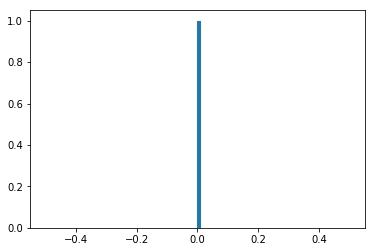

TypeError: Invalid dimensions for image data

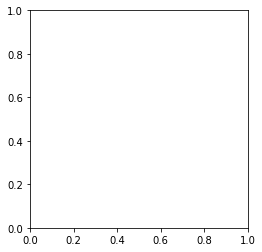

In [10]:
plt.hist(day_argmax.flatten() - night_argmax.flatten(), bins=100);
plt.show()
plt.imshow(day_argmax - night_argmax);

In [11]:
np.mean(day_argmax.flatten() - night_argmax.flatten())

0.0

In [ ]:
len(days), len(nights)

In [ ]:
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
days_sum, nights_sum=[],[]
day_an, night_an = [],[]
for year in range(2003,2020):

    day_files, night_files = get_fire_year_files(raster_folder, var, year)

    day_sum = nansum(day_files)
    night_sum = nansum(night_files)
    
    days_sum.append(day_sum)
    nights_sum.append(night_sum)


    day_title = 'FY-{} Sum MODIS AFC - Daytime'.format(year)
    #day_an.append(gen_plot_xarr(day_sum, raster_folder, day_title))
    
    night_title = 'FY-{} Sum AFC - Nighttime'.format(year)
    #night_an.append(gen_plot_xarr(night_sum, raster_folder, night_title))
    
    #print('*************************************************************************')

In [ ]:
np.ma.array(days_sum).shape

In [ ]:
# total sum:
tot_day_sum = np.nansum(np.ma.array(days_sum), axis=0)
tot_night_sum = np.nansum(np.ma.array(nights_sum), axis=0)


# Look at Fire Season Length

we define the duration of the fire season as the number of months during which the average monthly overpass‐corrected fire counts was at least 10% of the average annual overpass‐corrected fire counts.

We can look at this per year, where we calculate the 10% mark and find number of pixels per row-column entry that extend above that.

In [14]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 0

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 0
    


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 144, 'height': 72, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.5, 0.0, -178.875,
       0.0, -2.5, 88.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [15]:
def calc_fire_season(files_array):
    
    # stack the files
    arr,_ = stack(files_array, nodata=-32768)
    
    # take the mean across the time axis
    p10 = np.nanmean(arr, axis=0)*0.1
    
    # sum across time axis
    fs_arr = arr > p10
    
    
    return fs_arr.sum(axis=0)

# need to figure out the best way to get the overpass correction integrated monthly
def calc_fire_season_agg_oc(files_array, agg_fac=1):
    
    # stack the files
    arr,_ = es_stack(files_array, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*30.44/2, 0)
    arr *= op_oc
    arr = np.ma.masked_equal(arr, -32768)
    
    p10 = np.nanmedian(arr, axis=0)*0.1
    #print(f'p10: {np.nansum(p10)}')
    #arr*= op_oc #op_0_25*30.44/2 # number of days per year, divide by two for night/day. NEED TO DO PER MONTH... avg. days per mo?
    
    arr_list = []
    if agg_fac > 1:
        
        for a in arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        arr = np.array(arr_list)
    
    
    
    #rr[arr == 0] = np.nan
    # take the mean across the time axis
    p10 = np.nanmean(arr, axis=0)*0.1
    #print(f'after agg p10: {np.nansum(p10)}')
    
    # sum across time axis
    fs_arr = arr > p10    
    
    fs_sum = np.ma.sum(fs_arr, axis=0)
    fs_sum = np.ma.masked_equal(fs_sum, 0)
    return fs_sum
    

days_fl, nights_fl=[],[]
day_an, night_an = [],[]
# for year in range(2003,2019):
for year in range(2003,2020): # data update 11/11/2020
    
    day_files, night_files = get_fire_year_files(raster_folder, var, year)

    #day_fl = calc_fire_season(day_files)
    #night_fl = calc_fire_season(night_files)
    
    agg = 4
    day_fl = calc_fire_season_agg_oc(day_files, agg_fac=agg)
    night_fl = calc_fire_season_agg_oc(night_files, agg_fac=agg)
    
    days_fl.append(day_fl)
    nights_fl.append(night_fl)
    
    day_title = 'FY-{} Fire Season Length AFC - Daytime'.format(year)
    #day_an.append(gen_plot_xarr(day_fl, raster_folder, day_title, cmap='Spectral_r'))
    
    night_title = 'FY-{} Fire Season Length - Nighttime'.format(year)
    #night_an.append(gen_plot_xarr(night_fl, raster_folder, night_title, cmap='Spectral_r'))
    
    #print('*************************************************************************')

In [16]:
# debug block reduce
arr,_ = es_stack(day_files, nodata=-32768)
print(type(arr))
op_oc = np.ma.masked_equal(op_0_25*30.44/2, 0)
print(type(op_oc))
arr *= op_oc
print(type(arr))
#arr = np.ma.masked_equal(arr, -32768)

# arr_resized = np.array([ block_reduce(a, (agg_fac, agg_fac), np.nansum) for a in arr])
for a in arr:
    a[a.mask] = 0
    temp = block_reduce(a, (agg, agg), func=np.ma.sum)
    print(type(temp), np.ma.sum(temp), np.sum(a))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'> 16137389.0 16137392.0
<class 'numpy.ma.core.MaskedArray'> 16892332.0 16892336.0
<class 'numpy.ma.core.MaskedArray'> 12392667.0 12392666.0
<class 'numpy.ma.core.MaskedArray'> 21701018.0 21701018.0
<class 'numpy.ma.core.MaskedArray'> 36716124.0 36716116.0
<class 'numpy.ma.core.MaskedArray'> 33791656.0 33791656.0
<class 'numpy.ma.core.MaskedArray'> 23304648.0 23304650.0
<class 'numpy.ma.core.MaskedArray'> 13658803.0 13658804.0
<class 'numpy.ma.core.MaskedArray'> 11441354.0 11441351.0
<class 'numpy.ma.core.MaskedArray'> 17428928.0 17428926.0


try scipy.stats.linregress and apply along axis

In [17]:
oc = True

# no overpass correction
day_arr = np.array(days_fl)
night_arr = np.array(nights_fl)


In [18]:
from scipy.stats import linregress

Try as row vectors first

In [19]:
s,i,r,p,ste, n = [],[],[],[],[],[]
x = np.arange(night_arr.shape[0])
y_arr = np.rollaxis(night_arr,0,3)
y_arr = np.reshape(y_arr, (night_arr.shape[1]*night_arr.shape[2], night_arr.shape[0]))
for y in y_arr:
    _s, _i, _r, _p, _ste = linregress(x,y)
    _n = ~np.isnan(y).sum()
    
    s.append(_s)
    i.append(_i)
    r.append(_r)
    p.append(_p)
    ste.append(_ste)
    n.append(_n)

In [20]:
s_arr = np.array(s).reshape(night_arr.shape[1:])
p_arr = np.array(p).reshape(night_arr.shape[1:])

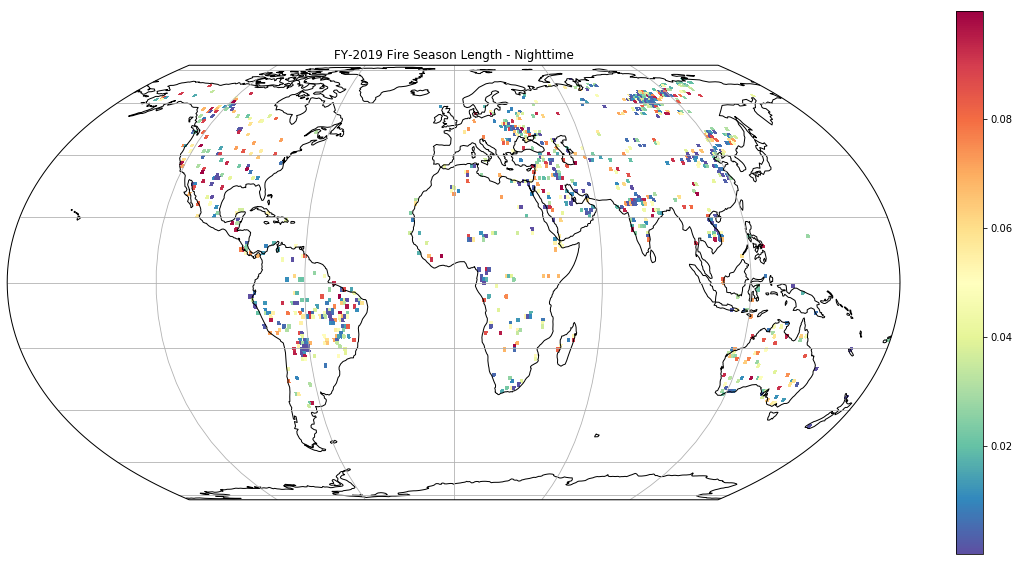

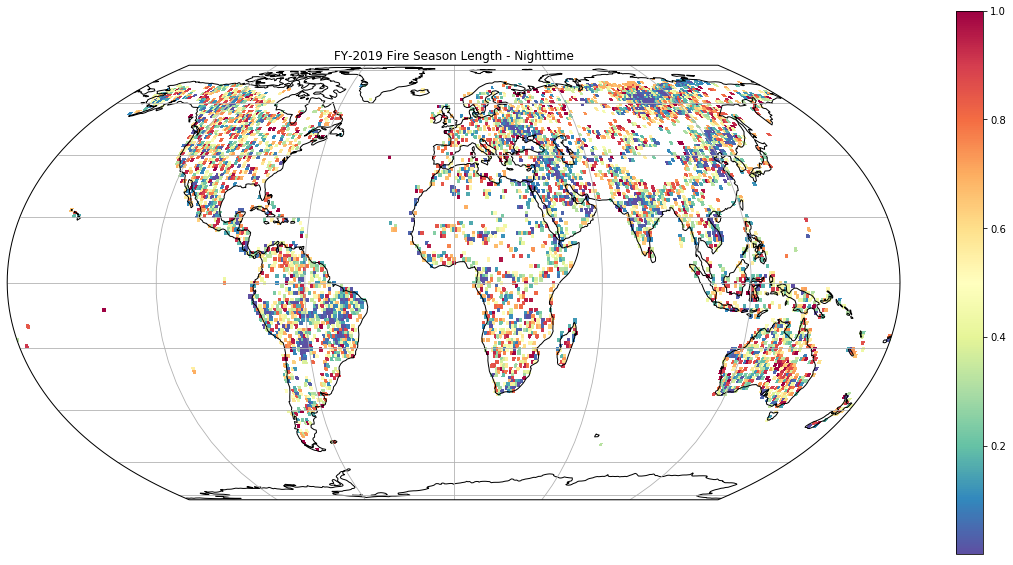

In [21]:
gen_plot_xarr(np.where((p_arr < 0.1) & (s_arr > 0), p_arr, np.nan), raster_folder, night_title, cmap='Spectral_r', agg=agg);
gen_plot_xarr(np.where((s_arr > 0), p_arr, np.nan), raster_folder, night_title, cmap='Spectral_r', agg=agg);


In [22]:
norm=True
if norm:
    # try to normalize the data
    day_max = day_arr.max()
    day_min = day_arr.min()
    night_max = night_arr.max()
    night_min = night_arr.min()
    tot_min = min(night_min, day_min)
    tot_max = max(night_max, day_max)
    test_day = (day_arr - tot_min) / (tot_max - tot_min)
    test_night = (night_arr - tot_min) / (tot_max - tot_min)
    #test_years -= base_year # normalize
        

In [23]:
s,i,r,p,ste, n = [],[],[],[],[],[]
x = np.arange(night_arr.shape[0])
y_arr = np.rollaxis(test_night,0,3)
y_arr = np.reshape(y_arr, (test_night.shape[1]*test_night.shape[2], test_night.shape[0]))
for y in y_arr:
    _s, _i, _r, _p, _ste = linregress(x,y)
    #_n = ~np.isnan(y).sum()
    _n = (y>0).sum()
    
    s.append(_s)
    i.append(_i)
    r.append(_r)
    p.append(_p)
    ste.append(_ste)
    n.append(_n)

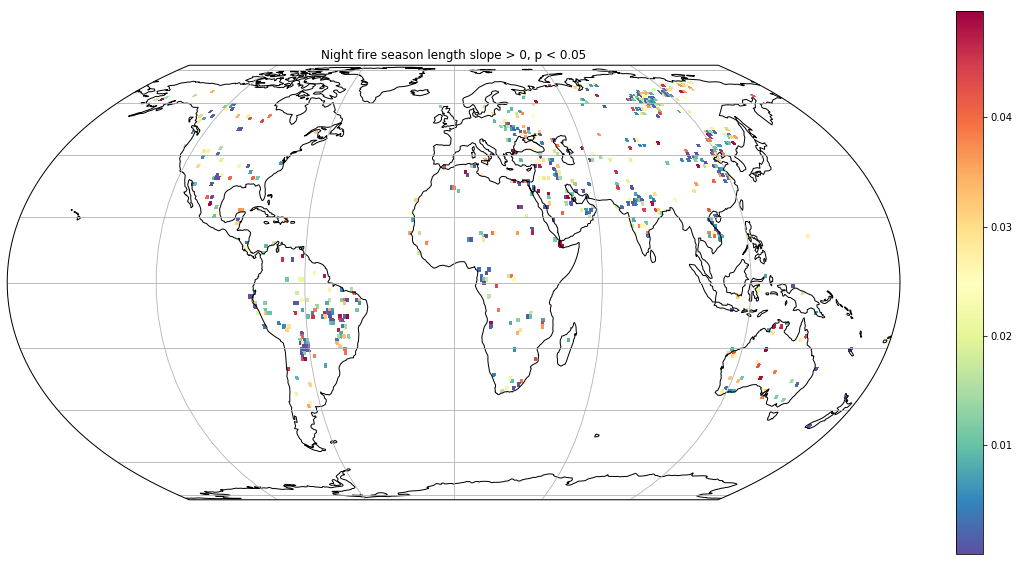

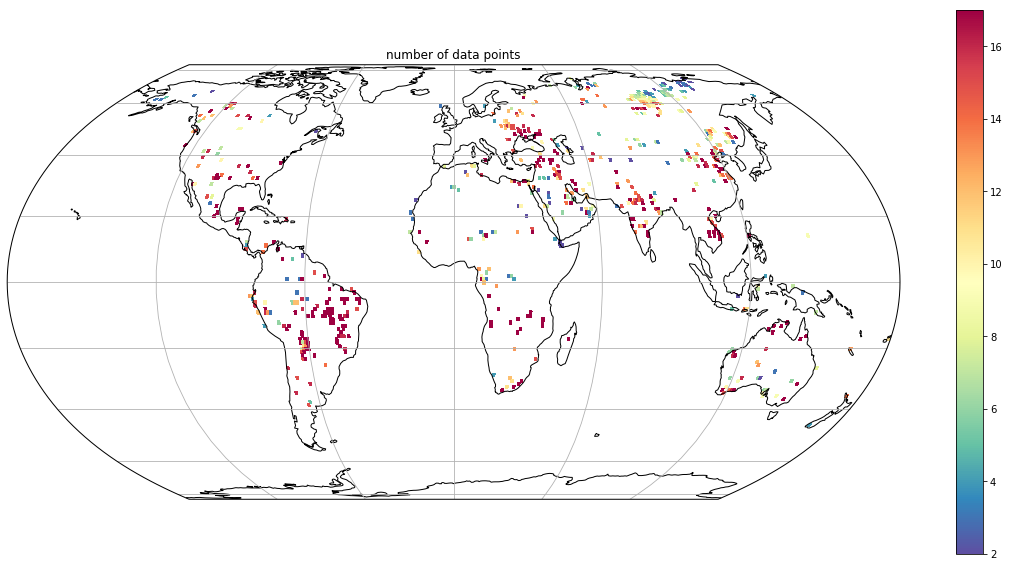

In [24]:
s_arr = np.array(s).reshape(night_arr.shape[1:])
p_arr = np.array(p).reshape(night_arr.shape[1:])
n_arr = np.array(n).reshape(night_arr.shape[1:])

night_title = 'Night fire season length slope > 0, p < 0.05'
gen_plot_xarr(np.where((p_arr < 0.05) & (s_arr > 0), p_arr, np.nan), raster_folder, night_title, cmap='Spectral_r', agg=agg);
gen_plot_xarr(np.where((p_arr < 0.05) & (s_arr > 0), n_arr, np.nan), raster_folder, "number of data points", cmap='Spectral_r', agg=agg);

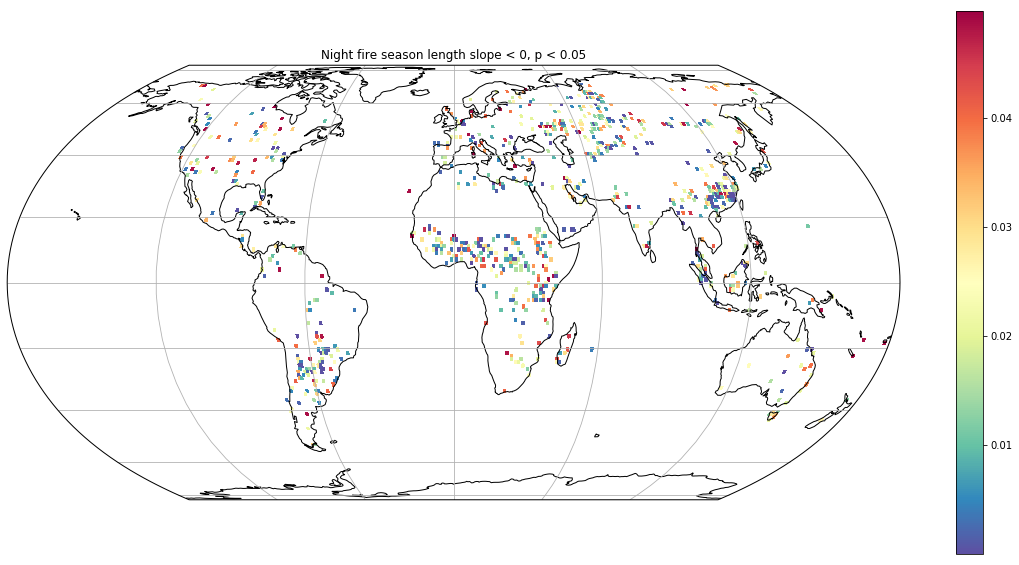

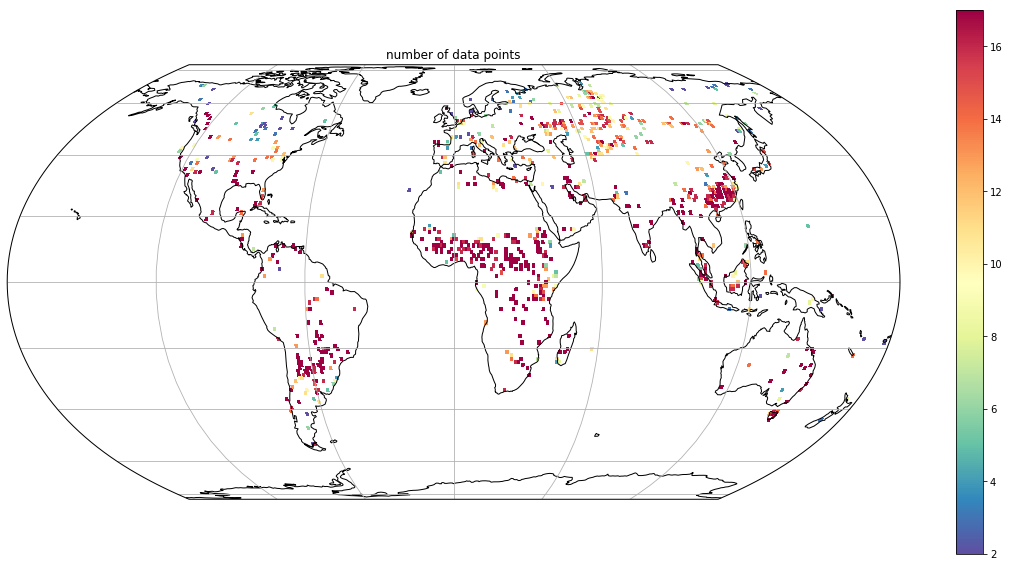

In [25]:
night_title = 'Night fire season length slope < 0, p < 0.05'
gen_plot_xarr(np.where((p_arr < 0.05) & (s_arr < 0), p_arr, np.nan), raster_folder, night_title, cmap='Spectral_r', agg=agg);
gen_plot_xarr(np.where((p_arr < 0.05) & (s_arr < 0), n_arr, np.nan), raster_folder, "number of data points", cmap='Spectral_r', agg=agg);

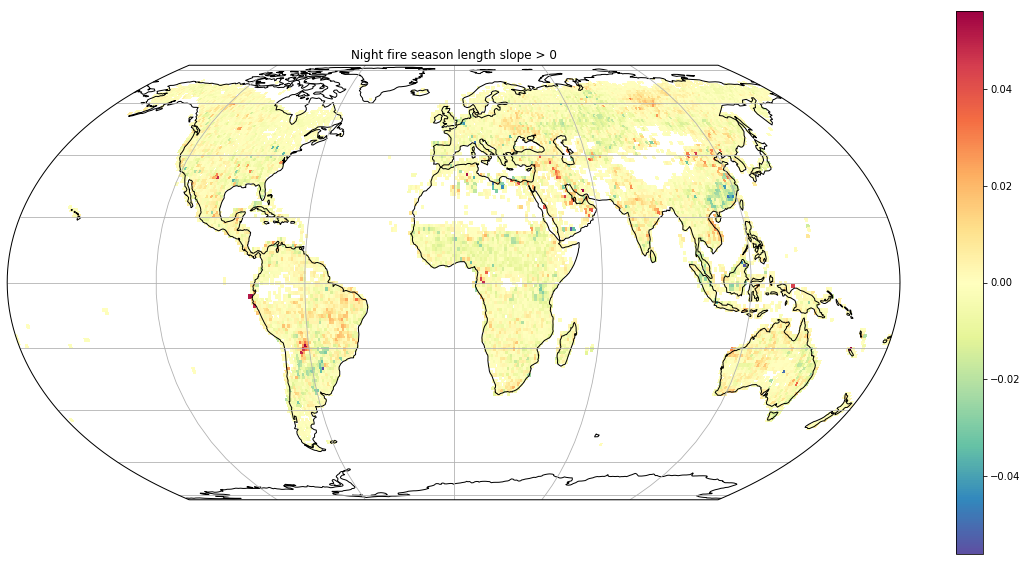

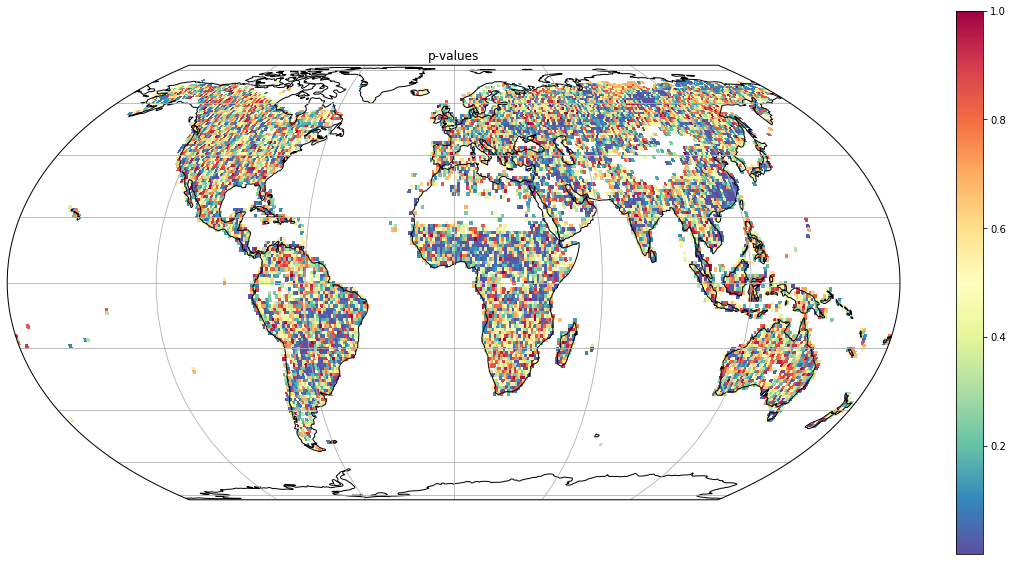

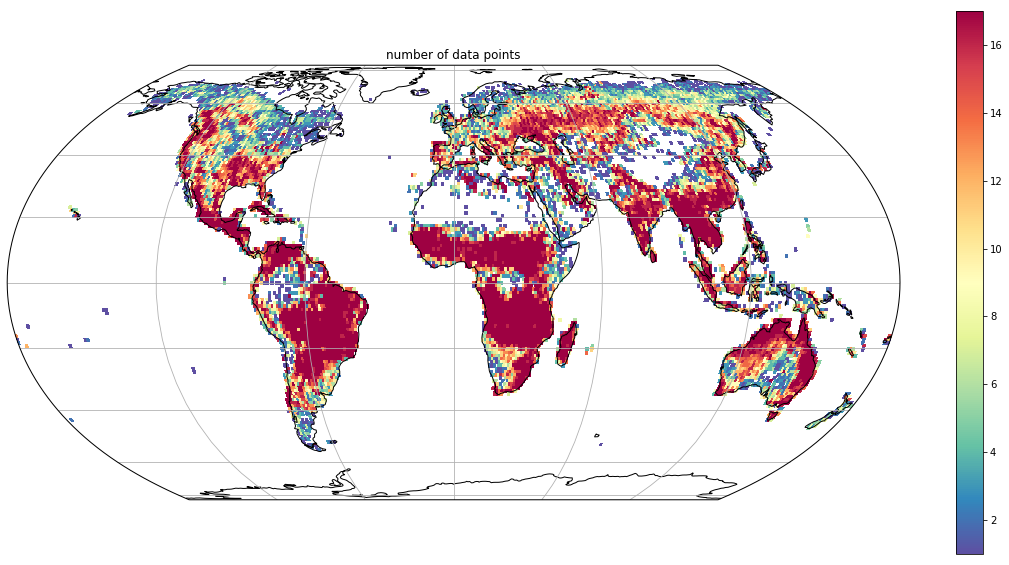

In [26]:
night_title = 'Night fire season length slope > 0'
gen_plot_xarr(s_arr, raster_folder, night_title, cmap='Spectral_r', agg=agg);
gen_plot_xarr(np.where(p_arr != 1, p_arr, np.nan), raster_folder, "p-values", cmap='Spectral_r', agg=agg);
gen_plot_xarr(n_arr, raster_folder, "number of data points", cmap='Spectral_r', agg=agg);

# Overpass corrected
### write out the nighttime data

In [27]:
folder = r'D:\projects\RD\night_fire\figs\global_refreshNov2020\fire_year\overpass_corrected_agg'
if not os.path.exists(folder):
    os.makedirs(folder)
    

In [28]:
    
# write out all nighttime rasters
fn = os.path.join(folder, 'all_pvals_fireyear.tif')
write_out(np.where(p_arr != 1, p_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_pos_fireyear.tif')
write_out(np.where(s_arr > 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_fireyear.tif')
write_out(np.where(s_arr < 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_numyears_fireyear.tif')
write_out(n_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = os.path.join(folder, 'all_night_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'all_night_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [29]:
# write out slopes where p < 0.05
fn = os.path.join(folder, 'BIN_all_night_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_night_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'BIN_all_night_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_night_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

### write out the nighttime data

In [30]:
# write out all nighttime rasters
fn = os.path.join(folder, 'all_pvals_fireyear.tif')
write_out(np.where(p_arr != 1, p_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_pos_fireyear.tif')
write_out(np.where(s_arr > 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_fireyear.tif')
write_out(np.where(s_arr < 0, s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_numyears_fireyear.tif')
write_out(n_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = os.path.join(folder, 'all_night_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'all_night_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_night_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')


In [31]:
# write out slopes where p < 0.05
fn = os.path.join(folder, 'BIN_all_night_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.05), s_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_night_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.05), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'BIN_all_night_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr > 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_night_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((s_arr < 0) & (p_arr <= 0.1), s_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

### do the same for daytime data

In [32]:
s_d,i_d,r_d,p_d,ste_d, n_d = [],[],[],[],[],[]
x = np.arange(day_arr.shape[0])
y_arr = np.rollaxis(test_day,0,3)
y_arr = np.reshape(y_arr, (test_day.shape[1]*test_day.shape[2], test_day.shape[0]))
for y in y_arr:
    _s, _i, _r, _p, _ste = linregress(x,y)
    #_n = ~np.isnan(y).sum()
    _n = (y>0).sum()
    
    s_d.append(_s)
    i_d.append(_i)
    r_d.append(_r)
    p_d.append(_p)
    ste_d.append(_ste)
    n_d.append(_n)

In [33]:
sd_arr = np.array(s_d).reshape(day_arr.shape[1:])
pd_arr = np.array(p_d).reshape(day_arr.shape[1:])
nd_arr = np.array(n_d).reshape(day_arr.shape[1:])

In [34]:
# write out all nighttime rasters
fn = os.path.join(folder, 'all_pvals_day_fireyear.tif')
write_out(np.where(pd_arr != 1, pd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_pos_fireyear.tif')
write_out(np.where(sd_arr > 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_fireyear.tif')
write_out(np.where(sd_arr < 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_numyears_fireyear.tif')
write_out(nd_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = os.path.join(folder, 'all_day_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'all_day_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [35]:
# write out slopes where p < 0.05
fn = os.path.join(folder, 'BIN_all_day_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_day_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'BIN_all_day_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_day_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [36]:
# write out all nighttime rasters

fn = os.path.join(folder, 'all_pvals_day_fireyear.tif')
write_out(np.where(pd_arr != 1, pd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_pos_fireyear.tif')
write_out(np.where(sd_arr > 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_fireyear.tif')
write_out(np.where(sd_arr < 0, sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_numyears_fireyear.tif')
write_out(nd_arr, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.05
fn = os.path.join(folder, 'all_day_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'all_day_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'all_day_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan), fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [37]:
# write out slopes where p < 0.05
fn = os.path.join(folder, 'BIN_all_day_slope_pos_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.05), sd_arr, np.nan) *0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_day_slope_neg_PVAL0_05_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.05), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# write out slopes where p < 0.1
fn = os.path.join(folder, 'BIN_all_day_slope_pos_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr > 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = os.path.join(folder, 'BIN_all_day_slope_neg_PVAL0_1_fireyear.tif')
write_out(np.where((sd_arr < 0) & (pd_arr <= 0.1), sd_arr, np.nan)*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

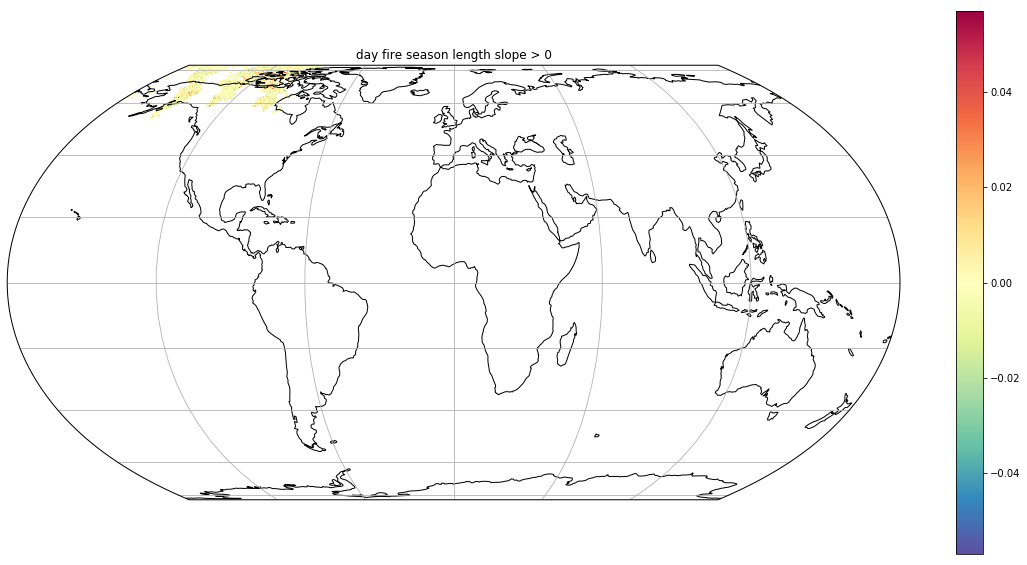

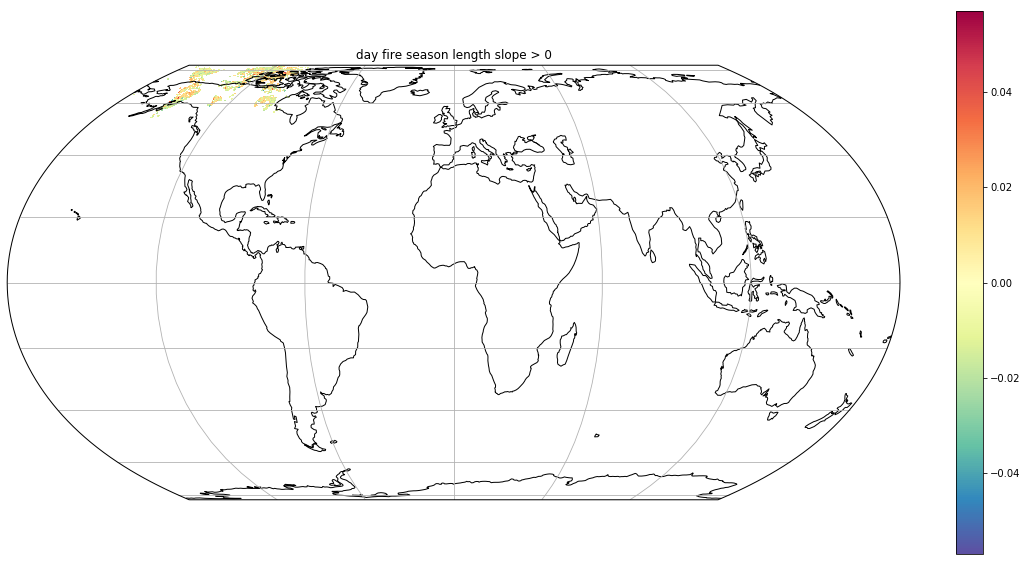

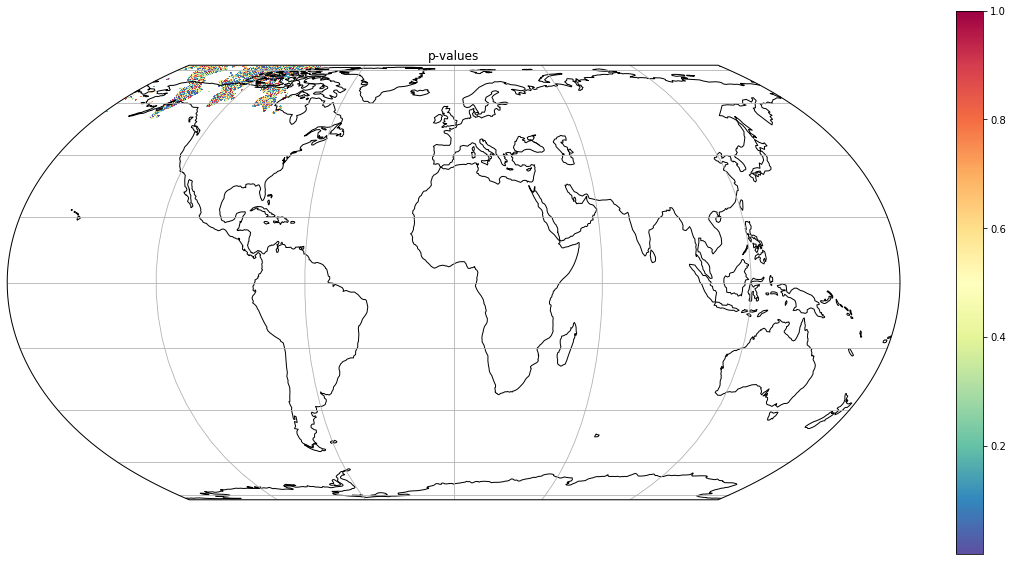

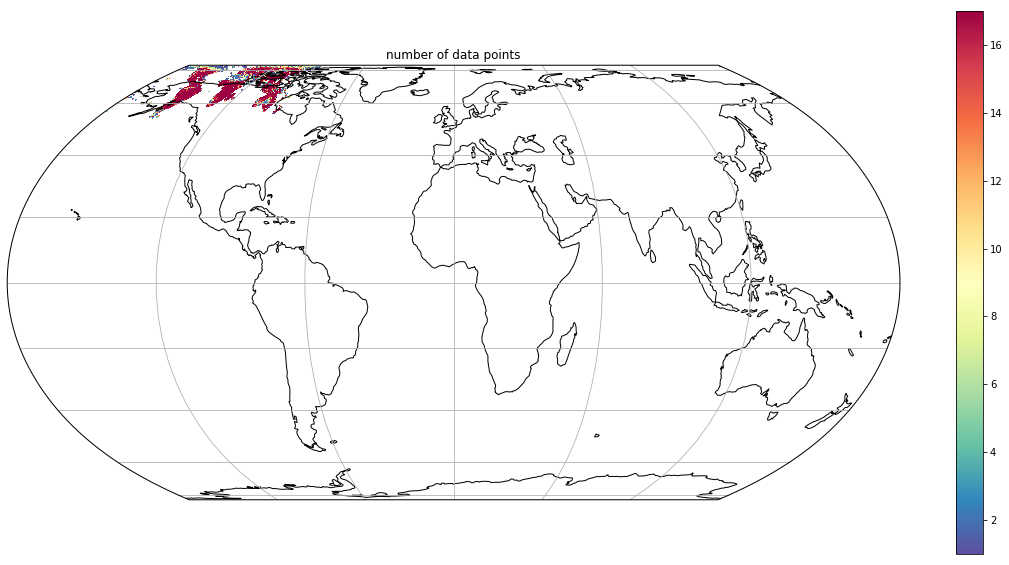

In [38]:
day_title = 'day fire season length slope > 0'
gen_plot_xarr(sd_arr, raster_folder, day_title, cmap='Spectral_r');
gen_plot_xarr(np.where(np.abs(sd_arr) >=0.01, sd_arr, np.nan), raster_folder, day_title, cmap='Spectral_r');
gen_plot_xarr(np.where(pd_arr != 1, pd_arr, np.nan), raster_folder, "p-values", cmap='Spectral_r');
gen_plot_xarr(nd_arr, raster_folder, "number of data points", cmap='Spectral_r');

In [ ]:
(sd_arr - s_arr).sum()

In [ ]:
night_title = 'night fire season length slope > 0'
gen_plot_xarr(s_arr, raster_folder, night_title, cmap='Spectral_r');
gen_plot_xarr(np.where(np.abs(s_arr) >=0.01, s_arr, np.nan), raster_folder, night_title, cmap='Spectral_r');
gen_plot_xarr(np.where(p_arr != 1, p_arr, np.nan), raster_folder, "p-values", cmap='Spectral_r');
gen_plot_xarr(n_arr, raster_folder, "number of data points", cmap='Spectral_r');

In [ ]:
np.abs(n_arr - nd_arr).sum()

In [ ]:
# np.apply_along_axis(linregress, 0, np.arange(day_arr.shape[0]), y=day_arr)
temp = np.apply_along_axis(linregress, 0, day_arr, y=np.arange(day_arr.shape[0]))

In [ ]:
s_day, i_day, r_day, p_day, stderr_day = temp

In [ ]:
gen_plot_xarr(np.where((p_day < 0.05) & (s_day > 0), p_day, np.nan), raster_folder, night_title, cmap='Spectral_r')

In [ ]:
night_arr = np.array(nights_fl)
temp_n = np.apply_along_axis(linregress, 0, night_arr, y=np.arange(night_arr.shape[0]))

In [ ]:
s_night, i_night, r_night, p_night, stderr_night = temp_n

In [ ]:
gen_plot_xarr(np.where((p_night < 0.05) & (s_night > 0), p_night, np.nan), raster_folder, night_title, cmap='Spectral_r')

In [ ]:
ex_x = np.arange(night_arr.shape[0])
ex_x = ex_x[np.newaxis, np.newaxis, :]


In [ ]:
temp_n = np.apply_along_axis(linregress, 0, ex_x, y=night_arr)

In [ ]:
n=10
_,_,_,_=plot_regress_var(np.array(days_fl), np.array(nights_fl),
                 raster_folder, af_var='AFC_num', reg_month='FIRE SEASON LENGTH', reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-.06, # was 3000 un normalized
                    absmax=.06,
                    cm='coolwarm',
                    save=False,
                    save_dir="",
                    cartoplot=True,
                    norm=True,
                    min_year=None)

In [ ]:
n=10
plot_regress_var(np.array(days_fl), np.array(nights_fl),
                 raster_folder, af_var='AFC_num', reg_month='FIRE SEASON LENGTH', reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-0.75, # was 3000 un normalized
                    absmax=0.75,
                    cm='coolwarm',
                    save=False,
                    save_dir="",
                    cartoplot=True,
                    norm=False,
                    min_year=None)

## check the overpass estimate raster

In [ ]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 0

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 0
    

plt.figure(figsize=(10,5))
plt.imshow(op_0_25)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(op_0_2_5)
plt.colorbar()
plt.show()


In [ ]:
n=10
dson_slope, nson_slope, nd_slope_ratio, nd_slope_dif= plot_regress_var(np.array(days_fl), np.array(nights_fl),
                                                                         raster_folder, af_var='AFC_num', reg_month='SUM', reg_var='slope', n_obsv=n, agg_fact=1,
                                                                            absmin=-0.03, # was 3000 un normalized
                                                                            absmax=0.01,
                                                                            cm='gnuplot',
                                                                            save=False,
                                                                            save_dir="",
                                                                            cartoplot=True,
                                                                            norm=True,
                                                                            min_year=None)

In [ ]:
night_slope_sign = np.sign(nson_slope)
day_slope_sign = np.sign(dson_slope)

night_slope_pos = np.where(night_slope_sign > 0, nson_slope, np.nan)

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where Night Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (overpass corrected)', cmap='coolwarm');

In [ ]:
night_slope_sign = np.sign(nson_slope)
day_slope_sign = np.sign(dson_slope)

night_slope_pos = np.where(night_slope_sign > 0, nson_slope, np.nan)
day_slope_pos = np.where(day_slope_sign > 0, dson_slope, np.nan)

night_slope_neg = np.where(night_slope_sign < 0, nson_slope, np.nan)
day_slope_neg = np.where(day_slope_sign < 0, dson_slope, np.nan)

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where Night Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (not overpass corrected)');

# plot it
_ = gen_plot_xarr(night_slope_pos, raster_folder, title='Where DAY Time Slope Across Fire Years 2003-2018 is Positive\n \
                  Active Fire Counts Summed Across Each Fire Year (not overpass corrected)');

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = night_slope_pos[~np.isnan(night_slope_pos)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with positive NIGHT time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = day_slope_pos[~np.isnan(day_slope_pos)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with positive DAY time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = day_slope_neg[~np.isnan(day_slope_neg)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with negative DAY time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# a 0.1 deg latitude is 11km @ equator... so 2.5 deg is 275km. 
# an equal area world projection maps to 278298.727 meters for x-y dimensions (World_Cylindrical_Equal_Area) 2.5 deg
# an equal area world projection maps to 27829.872 meters for x-y dimensions (World_Cylindrical_Equal_Area) 0.25 deg

eq_area = 27829.872
# earth surface area with positive night time fire slope:
num_pos_pixels = night_slope_neg[~np.isnan(night_slope_neg)].size
surf_area = num_pos_pixels*eq_area*eq_area
surf_area_km2 = surf_area / 1000 / 1000
print(f'earth surface area with negative NIGHT time fire slope: {surf_area_km2:.2E} km^2')

# total surface area of earth 148.847x10^6 km2
earth_land_surf_area_km2 = 148.847e6
print(f'% of land surface: {100*surf_area_km2/earth_land_surf_area_km2:.2f}%')

In [ ]:
# compare histograms
plt.figure(figsize=(20,10))
plt.hist(night_slope_pos.ravel(), bins=100, alpha=0.2, edgecolor='k', label='FY Length Trend Positive')
plt.legend(fontsize=13)
plt.xlabel('Normalized Slope', fontsize=13)
plt.ylabel('# 0.25 Deg Pixels', fontsize=13)
plt.show()

In [ ]:
day_files
with rio.open(day_files[3]) as src:
    tform = src.profile['transform']

In [ ]:
num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = night_slope_neg*0+1
nplot = night_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=1, cmap='coolwarm', add_colorbar=False) # blue
x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r',add_colorbar=False)    # red

# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where NIGHT slope is positive (blue) and negative (red)')
plt.show()

In [ ]:
num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = day_slope_neg*0+1
nplot = day_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,10))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()

x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm',add_colorbar=False)    # blue
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r', add_colorbar=False) # red


# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where DAY slope is positive (blue) and negative (red)')
plt.show()

In [ ]:
# where night and day slope is positive


num_x = night_slope_neg.shape[1]
num_y = night_slope_neg.shape[0]
# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a, tform.c+num_x*tform.a, num_x)
tlat = np.linspace(tform.f - tform.e, tform.f+num_y*tform.e, num_y)

dplot = day_slope_pos*0+1
nplot = night_slope_pos*0+1

x_dplot = xr.DataArray(dplot, coords=[tlat, tlon], dims=['lat', 'lon'])
x_nplot = xr.DataArray(nplot, coords=[tlat, tlon], dims=['lat', 'lon'])

fig,ax = plt.subplots(figsize=(20,18))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
# ax.gridlines()
# x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.15, cmap='autumn', add_colorbar=False)
# x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.15, cmap='winter',add_colorbar=False)

# night positive
x_nplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.3, cmap='coolwarm', add_colorbar=False) # blue

# day positive
x_dplot.plot(ax=ax, transform=ccrs.PlateCarree(), alpha=0.1, cmap='coolwarm_r',add_colorbar=False)    # red

# ax.imshow(nplot, alpha=1., cmap='coolwarm') # blue, night
# ax.imshow(dplot, alpha=0.25, cmap='coolwarm_r') # red, day
plt.title('Where NIGHT slope is positive (blue) and DAY slope is positive (red)')
plt.show()

In [ ]:
# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        


In [ ]:
fn = r'D:\projects\RD\night_fire\figs\global\fire_year\day_slope_pos_fireyear.tif'
write_out(day_slope_pos*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\day_slope_neg_fireyear.tif'
write_out(day_slope_neg*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\night_slope_pos_fireyear.tif'
write_out(night_slope_pos*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\fire_year\night_slope_neg_fireyear.tif'
write_out(night_slope_neg*0+1, fn, 'climate_grid_meta_0_25_wgs84.pickle')

In [ ]:
print('day\tnight')
print(np.nansum(day_slope_pos*0+1), np.nansum(night_slope_pos*0+1))
print(np.nansum(day_slope_neg*0+1), np.nansum(night_slope_neg*0+1))
print(np.nansum(dson_slope*0+1), np.nansum(nson_slope*0+1))

In [ ]:
# construct the region object
numbers = conus_wgs84.index
names = [str(i) for i in conus_wgs84.OBJECTID]
abbrevs = [str(i) for i in conus_wgs84.OBJECTID]
geoms = list(conus_wgs84.geometry)
rmask = regionmask.Regions_cls('USmask', numbers, names, abbrevs, geoms)

# construct the mask, matching spatial coordinate dimensions
data_mask = rmask.mask(data, lon_name='x', lat_name='y')

# mask the data, as well as nodata
nodata=-32768
masked_data = data.where(data_mask>=0)
masked_data = masked_data.where(masked_data!=nodata)
masked_data.plot(figsize=(20,10))
masked_data.min(), masked_data.max()

## using regionmask for data masking (test stuff)

In [ ]:
import regionmask
import xshape
import geopandas as gpd
import xarray as xr

In [4]:
conus = gpd.read_file('../CONUS_boundary/CONUS_boundary.shp')
conus.plot()


NameError: name 'gpd' is not defined

In [ ]:
conus_wgs84 = conus.to_crs(epsg=4326)

In [ ]:
# try to use regionmask to clip xarray
day_files, night_files = get_fire_year_files(raster_folder.replace('2_5', '0_25'), var, 2010)
data = xr.open_rasterio(day_files[1])
data